In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [11]:
import random

def set_seed(seed):
    """
    Set the seed for reproducibility.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Set the seed for numpy for reproducibility
    random.seed(seed)  # Set Python random seed
    # Ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False

# Example: Setting the seed to 42
set_seed(42)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Using device: cuda


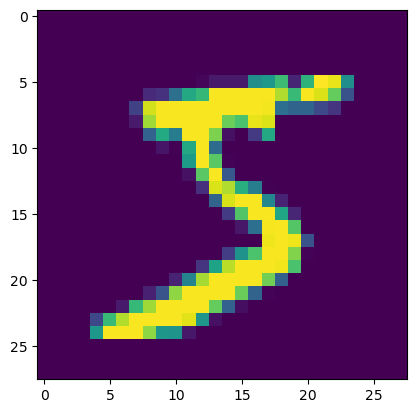

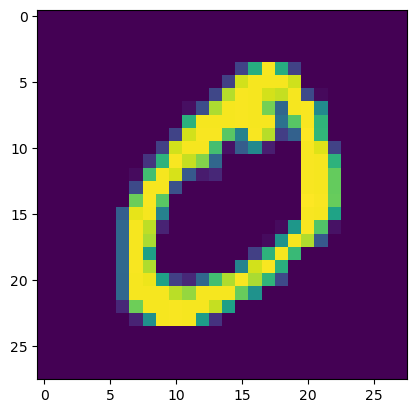

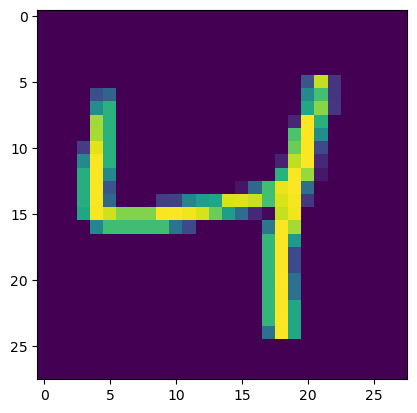

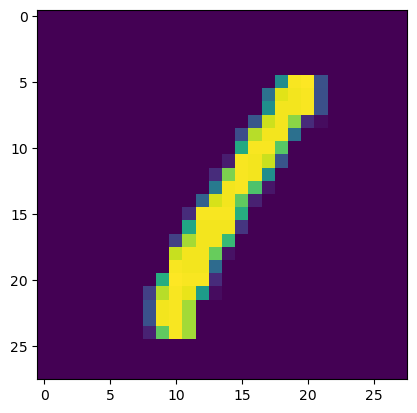

In [13]:
all_images = []
all_indices = []

for i, (images, labels) in enumerate(trainloader):
    all_images.extend(images)
    all_indices.extend(range(i * len(images), (i + 1) * len(images)))

# Convert the list to a NumPy array
all_images = torch.stack(all_images)
all_indices = torch.tensor(all_indices)



# Function to display an image given its index
def imshow_by_index(index):
    img = all_images[index] / 2 + 0.5  # Unnormalize
    plt.imshow(img.permute(1, 2, 0))  # Convert from Tensor image
    plt.show()

# Example: Display the first four images
for i in range(4):
    imshow_by_index(i)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrainableNode(nn.Module):
    def __init__(self, input_features, output_features):
        super(TrainableNode, self).__init__()
        self.linear = nn.Linear(input_features, output_features)
    
    def forward(self, x):
        return self.linear(x)

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Assuming MNIST images are 1x28x28 (channels x width x height)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) # Output: 64x14x14
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x7x7 after pooling
        
        # Flatten: 64*7*7 = 3136 features
        self.fc1 = nn.Linear(3136, 128) # Fully connected layer
        
        # Trainable node for explainability, assuming it requires a flattened input
        self.explainable_node = TrainableNode(128, 1)
        
        self.fc2 = nn.Linear(128, 64) # Additional fully connected layer
        self.fc3 = nn.Linear(64, 10) # Final layer for classifying into 10 classes
        
    def forward(self, x, return_explainable=False):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        x1 = F.relu(self.fc1(x))
        
        if return_explainable:
            explainable_output = self.explainable_node(x1).squeeze()
        
        x = F.relu(self.fc2(x1))
        x = self.fc3(x)
        
        if return_explainable:
            return x, explainable_output
        return x

class ExplainableNetwork:
    def __init__(self, model):
        self.model = model
        self.activations_per_input = {}
        self.weights_per_layer = {}
        self.gradients_per_input = {} 
        self.current_epoch = 0
        self.num_epochs = 0
        self.batch_counter = 0

        self.expected_outputs = []
        self.predicted_outputs = []
        
        # Register hooks for each layer
        for name, module in model.named_modules():
            if name == 'explainable_node':  # Skip the explainable_node by its name
                continue
            if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):  # Include Conv1d here
                self.weights_per_layer[name] = None
                module.register_forward_hook(self.create_forward_hook(name))
                module.register_full_backward_hook(self.create_backward_hook(name))


    def create_forward_hook(self, layer_name):
        def forward_hook(module, input, output):
            # On the last epoch, store activations for each input
            if self.current_epoch == self.num_epochs - 1:
                self.store_activations(layer_name, output)
            # Always store the current weights
            self.weights_per_layer[layer_name] = module.weight.data.clone()
        return forward_hook

    def create_backward_hook(self, layer_name):
        def backward_hook(module, grad_input, grad_output):
            # Only store gradients on the last epoch
            if self.current_epoch == self.num_epochs - 1:
                # grad_output[0] contains the gradient with respect to the output of the layer
                self.store_gradients(layer_name, grad_output[0])
        return backward_hook


    def store_activations(self, layer_name, output):
        self._store_per_input(self.activations_per_input, layer_name, output)

    def store_gradients(self, layer_name, gradient):
        # Store gradients for the last epoch
        if self.current_epoch == self.num_epochs - 1:
            batch_size = gradient.size(0)
            for i in range(batch_size):
                input_index = self.batch_counter * batch_size + i
                if input_index not in self.gradients_per_input:
                    self.gradients_per_input[input_index] = {}
                self.gradients_per_input[input_index][layer_name] = gradient[i].detach().cpu().numpy()
    
            # Increment the backward batch counter only after processing the first layer (which is the last layer in the forward pass)


    def _store_per_input(self, storage_dict, layer_name, tensor):
        batch_size = tensor.size(0)
        for i in range(batch_size):
            input_index = self.batch_counter * batch_size + i
            if input_index not in storage_dict:
                storage_dict[input_index] = {}
            storage_dict[input_index][layer_name] = tensor[i].detach().cpu().numpy()

        if layer_name == list(self.model.named_modules())[-1][0]:
            self.batch_counter += 1

    def start_epoch(self, epoch, num_epochs):
        self.current_epoch = epoch
        self.num_epochs = num_epochs
        if epoch == num_epochs - 1:
            self.batch_counter = 0  # Reset the batch counter on the last epoch

    def get_activations(self, input_index):
        return self.activations_per_input.get(input_index, None)

    def get_gradients(self, input_index):
        return self.gradients_per_input.get(input_index, None)

    def print_structure(self):
        print("Explainable Network Structure and Data Summary:")

        # Check if there is any data collected
        if not self.activations_per_input:
            print("No activations data collected.")
            return

        if not self.gradients_per_input:
            print("No gradients data collected.")
            return

        # Print information about activations
        print("\nActivations:")
        first_input_activations = next(iter(self.activations_per_input.values()))
        for layer_name, activations in first_input_activations.items():
            num_nodes = len(activations)
            num_data_points = len(self.activations_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

        # Print information about gradients
        print("\nGradients:")
        first_input_gradients = next(iter(self.gradients_per_input.values()))
        for layer_name, gradients in first_input_gradients.items():
            num_nodes = len(gradients)
            num_data_points = len(self.gradients_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

    def get_node_input(self, layer_name, node_index, image_index):

        if layer_name == 'fc1':
            # For the first layer, the input is the raw image data
            # Assuming you have a way to access the raw input images
            pass
        else:
            # For subsequent layers, we use activations from the previous layer
            prev_layer_name = self.get_previous_layer_name(layer_name)
            prev_activations = self.activations_per_input[image_index][prev_layer_name]

            # Ensure the prev_activations is a 1D array for proper multiplication
            if prev_activations.ndim > 1:
                prev_activations = prev_activations.flatten()

        return prev_activations
            
    def get_previous_layer_name(self, current_layer_name):
        # Correctly compare current_layer_name with expected values
        if current_layer_name == 'fc3':
            return 'fc2'
        elif current_layer_name == 'fc2':
            return 'fc1'
        return None

In [23]:
import torch.optim as optim

# Instantiate the model and move it to the GPU if available
model = MNISTNet().to(device)

# Set the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer (e.g., Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
model = MNISTNet().to(device)
explainable_net = ExplainableNetwork(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    explainable_net.start_epoch(epoch, num_epochs)
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        if epoch == num_epochs - 1:
            explainable_net.expected_outputs.extend(targets.cpu().numpy())
            
            # Convert outputs to predicted class labels
            _, predicted = torch.max(outputs, 1)
            explainable_net.predicted_outputs.extend(predicted.cpu().numpy())
        

In [25]:
explainable_net.print_structure()

Explainable Network Structure and Data Summary:

Activations:
Layer conv1: 32 nodes, 60000 data points each
Layer conv2: 64 nodes, 60000 data points each
Layer fc1: 128 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc3: 10 nodes, 60000 data points each

Gradients:
Layer fc3: 10 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc1: 128 nodes, 60000 data points each
Layer conv2: 64 nodes, 60000 data points each
Layer conv1: 32 nodes, 60000 data points each


In [26]:
sample_size = 10

print(len(explainable_net.expected_outputs))
print(len(explainable_net.predicted_outputs))

print("Sample of Expected Outputs:", explainable_net.expected_outputs[:sample_size])
print("Sample of Predicted Outputs:", explainable_net.predicted_outputs[:sample_size])

60000
60000
Sample of Expected Outputs: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
Sample of Predicted Outputs: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [27]:
def plot_scatter_for_extreme_outliers(explainable_network, layer_name, node_index, std_dev_threshold=3):
    activations = []
    gradients = []
    colors = []

    # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        if expected == predicted:
            activation = explainable_network.get_activations(input_index)
            gradient = explainable_network.get_gradients(input_index)

            if activation is not None and gradient is not None:
                activations.append(activation[layer_name][node_index])
                gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
                colors.append(color_map(expected))  # Color code based on the correct digit

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    colors = np.array(colors)

    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    colors_extreme = colors[extreme_outliers]

    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(activations_extreme, gradients_extreme, c=colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

# Example usage:
#plot_scatter_for_extreme_outliers(explainable_net, 'fc2', 3, std_dev_threshold=1.5)  # Adjust std_dev_threshold as needed


In [28]:
# Normalizes the predictions (i, j) to the total number of predictions(i, _) for all predictions
# Returns a 2D array such that probabilities[i][j] holds the probability of the model
# predicting last_layer[i] as last_layer[j]
def calculate_probabilities(classifier_outcomes, label_counts):
    probabilities = np.zeros_like(classifier_outcomes, dtype=np.float64)
    for i in range(len(label_counts)):
        if label_counts[i] > 0:  # Prevent division by zero
            probabilities[i] = classifier_outcomes[i] / label_counts[i]
    return probabilities


In [29]:
model.eval()
correct = 0
total = 0

final_layer_size = list(explainable_net.model.named_modules())[-1][1].out_features
# classifier_outcomes[i][j] will store the probability of the model incorrectly classifying digit i as digit j.
# The diagonals store the probability of a correct predicition
classifier_outcomes = np.zeros((final_layer_size, final_layer_size), dtype=np.float64)
label_counts = np.zeros(final_layer_size, dtype=np.int64)

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Initialize classifier_outcomes as the frequency of each prediction (label, pred)
        for label, pred in zip(labels, predicted):
            classifier_outcomes[label.item()][pred.item()] += 1
            # Store the number of total attempts at predicting 'label'
            label_counts[label.item()] += 1

classifier_outcomes = calculate_probabilities(classifier_outcomes, label_counts)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy}%')


Accuracy of the model on the 10000 test images: 99.13%


In [30]:
# Turns classifier_outcomes into a pandas.DataFrame for easier visualization
def display_classifier_outcomes_table(classifier_outcomes, mode='percent'):
    size = classifier_outcomes.shape[0]
    df = pd.DataFrame(classifier_outcomes, 
                      columns=[f'Predicted {j}' for j in range(size)], 
                      index=[f'Actual {i}' for i in range(size)])
    
    if mode == 'percent':
        df = df * 100
        fmt = "{:.4f}%"
    elif mode == 'probability':
        fmt = "{:.4f}"
    
    pd.set_option('display.float_format', fmt.format)
    
    # Display table
    print(df)

display_classifier_outcomes_table(classifier_outcomes, 'probability')

          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0       0.9969       0.0000       0.0010       0.0000       0.0000   
Actual 1       0.0000       0.9938       0.0026       0.0000       0.0009   
Actual 2       0.0000       0.0000       0.9990       0.0000       0.0000   
Actual 3       0.0000       0.0000       0.0030       0.9911       0.0000   
Actual 4       0.0000       0.0000       0.0000       0.0000       0.9868   
Actual 5       0.0011       0.0000       0.0000       0.0022       0.0000   
Actual 6       0.0031       0.0042       0.0000       0.0000       0.0010   
Actual 7       0.0000       0.0029       0.0068       0.0000       0.0000   
Actual 8       0.0041       0.0000       0.0010       0.0010       0.0000   
Actual 9       0.0010       0.0000       0.0000       0.0000       0.0040   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  Predicted 9  
Actual 0       0.0000       0.0000       0.0000       0.0010       0.0010  


In [31]:
layer_name = 'conv1'
node_index = 1
std_dev = 1.5

In [33]:
def plot_extreme_outliers(explainable_network, layer_name, node_index, std_dev_threshold=3, discriminate_classes=[-1,-1], Correct_pred_only=False):
    activations = []
    gradients = []
    colors = []
    labels = []
    classA = discriminate_classes[0]
    classB = discriminate_classes[1]
    
    # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        if expected == predicted or not Correct_pred_only:
            activation = explainable_network.get_activations(input_index)
            gradient = explainable_network.get_gradients(input_index)

            if activation is not None and gradient is not None:
                activations.append(activation[layer_name][node_index])
                gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
                colors.append(color_map(expected))  # Color code based on the correct digit
                labels.append(expected)

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    colors = np.array(colors)

    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers.flatten()]
    gradients_extreme = gradients[extreme_outliers.flatten()]
    labels_extreme = labels[extreme_outliers.flatten()]
    colors_extreme = colors[extreme_outliers.flatten()]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Activations': activations_extreme.flatten(), 'Gradients': gradients_extreme.flatten(), 'Labels': labels_extreme.flatten()})
    
    if classA > -1 and classB > -1:
        colors_extreme = colors_extreme[df['Labels'].isin([classA, classB])]
        df = df[df['Labels'].isin([classA, classB])]

    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c= colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

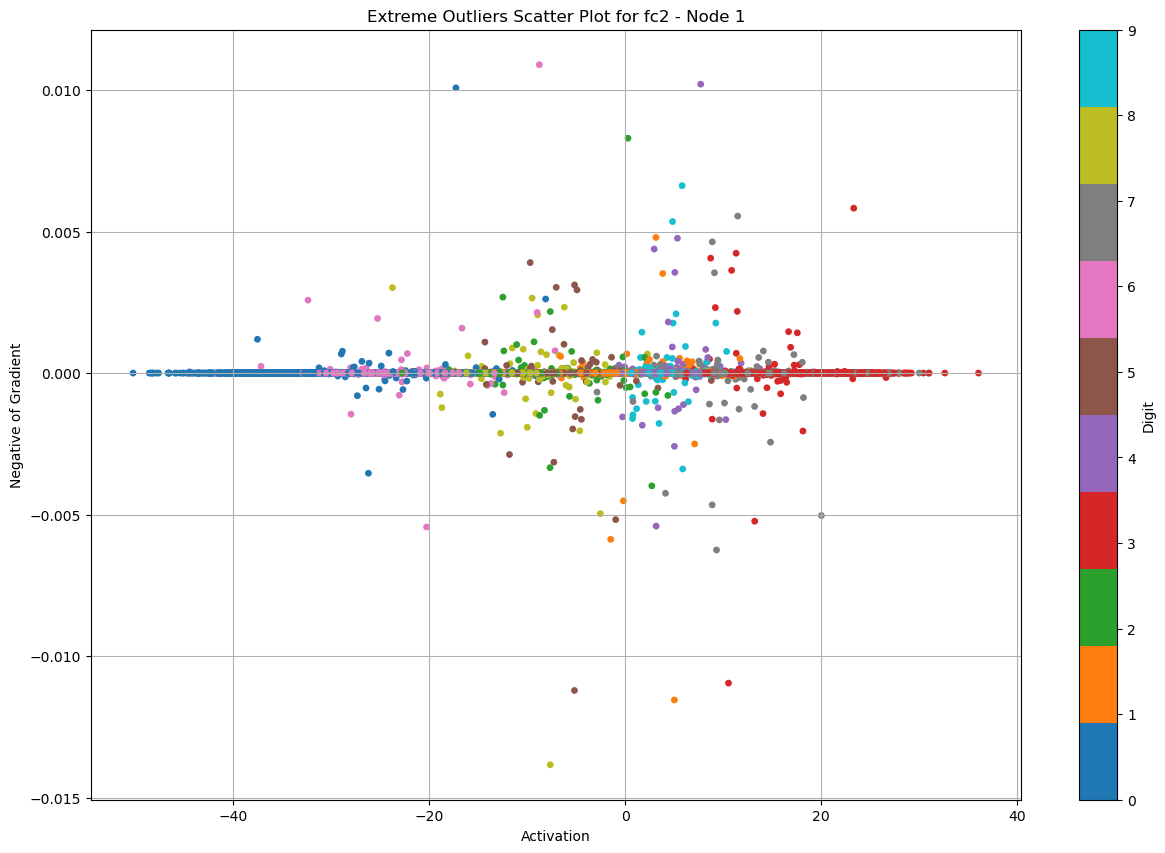

In [34]:
plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=0, Correct_pred_only=False)  # Adjust std_dev_threshold as needed

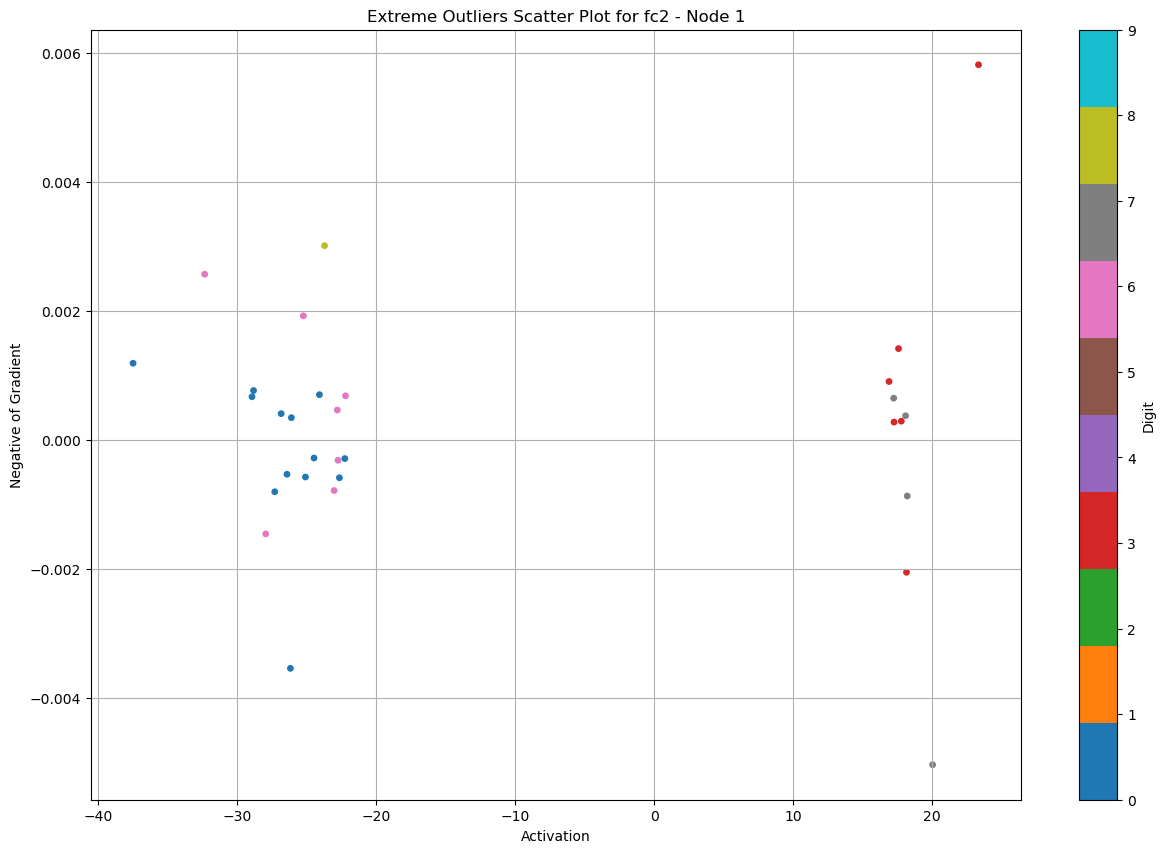

In [35]:
plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=std_dev, Correct_pred_only=False)  # Adjust std_dev_threshold as needed

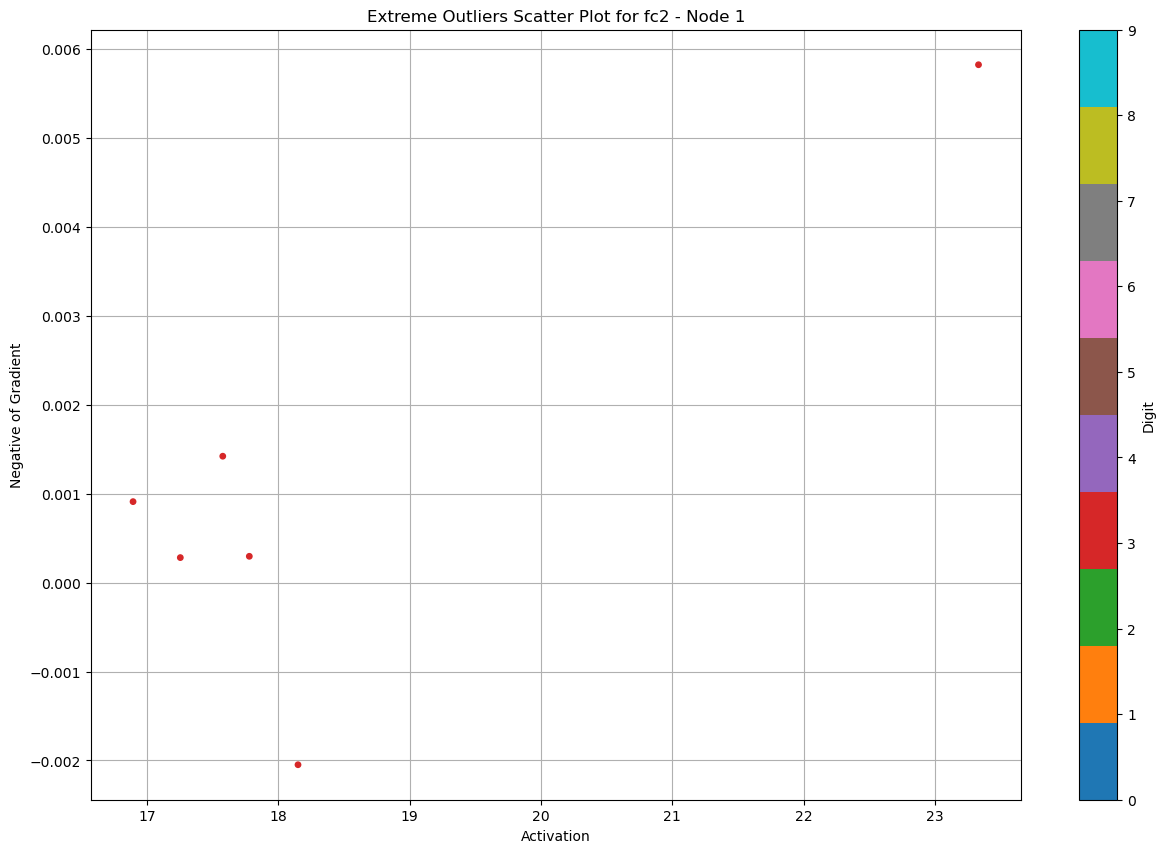

In [36]:
plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=std_dev, Correct_pred_only=False, discriminate_classes=[1,3])

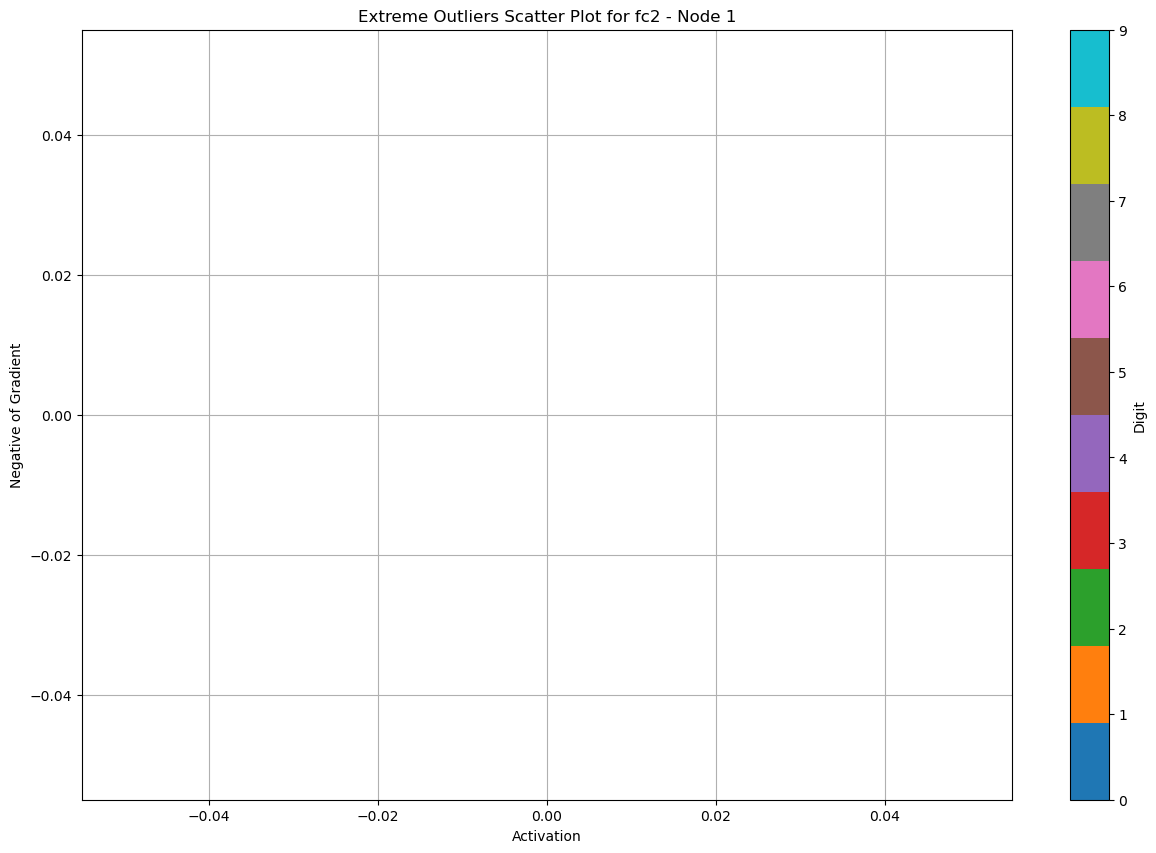

In [37]:
import pandas as pd

def plot_extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, selected_class=-1):
    activations = []
    gradients = []
    labels = []
    imgIndx = []
    colors = []
    
     # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)
            colors.append(color_map(expected))  # Color code based on the correct digit
            

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)
    colors = np.array(colors)


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers.flatten()]
    gradients_extreme = gradients[extreme_outliers.flatten()]
    labels_extreme = labels[extreme_outliers.flatten()]
    colors_extreme = colors[extreme_outliers.flatten()]
    imgIndx = imgIndx[extreme_outliers.flatten()]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Activations': activations_extreme.flatten(), 'Gradients': gradients_extreme.flatten(), 'Labels': labels_extreme.flatten()})
    
    if selected_class > -1:
        colors_extreme = colors_extreme[df['Labels'] == selected_class]
        df = df[df['Labels'] == selected_class]
        
    if quadrant == 1:
        colors_extreme = colors_extreme[df['Gradients'] > 0]
        df = df[df['Gradients'] > 0]
        colors_extreme = colors_extreme[df['Activations'] > 0]
        df = df[df['Activations'] > 0]
    elif quadrant == 2:
        colors_extreme = colors_extreme[df['Gradients'] > 0]
        df = df[df['Gradients'] > 0]
        colors_extreme = colors_extreme[df['Activations'] < 0]
        df = df[df['Activations'] < 0]
        
    elif quadrant == 3:
        colors_extreme = colors_extreme[df['Gradients'] < 0]
        df = df[df['Gradients'] < 0]
        colors_extreme = colors_extreme[df['Activations'] < 0]
        df = df[df['Activations'] < 0]
        
    elif quadrant == 4:
        colors_extreme = colors_extreme[df['Gradients'] < 0]
        df = df[df['Gradients'] < 0]
        colors_extreme = colors_extreme[df['Activations'] > 0]
        df = df[df['Activations'] > 0]
        
    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c=colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()


# Example usage:
plot_extreme_outliers_quad(explainable_net, layer_name, node_index, std_dev_threshold=1.5, quadrant= 1, selected_class=1)  # Adjust std_dev_threshold as needed



In [38]:
import pandas as pd

def extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, selected_class=-1):
    activations = []
    gradients = []
    labels = []
    imgIndx = []

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)
            

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers.flatten()]
    gradients_extreme = gradients[extreme_outliers.flatten()]
    labels_extreme = labels[extreme_outliers.flatten()]
    imgIndx = imgIndx[extreme_outliers.flatten()]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Index' : imgIndx.flatten(),'Activations': activations_extreme.flatten(), 'Gradients': gradients_extreme.flatten(), 'Labels': labels_extreme.flatten()})
    print(df)
    
    if selected_class > -1:
        df = df[df['Labels'] == selected_class]
        
    if quadrant == 1:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] > 0]
        
    elif quadrant == 2:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] > 0]
        
    elif quadrant == 3:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] < 0]
        
    elif quadrant == 4:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] < 0]
    
    return df['Index'].values


# Example usage:
displayPos = extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant=1)  # Adjust std_dev_threshold as needed
displayNeg = extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant=3)  # Adjust std_dev_threshold as needed

truePos =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant=1, selected_class=1)  
falsePos =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant=2, selected_class=2)  
trueNeg =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant=3, selected_class=3)  
falseNeg =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant=4, selected_class=4)

    Index  Activations  Gradients  Labels
0     149      18.1489    -0.0020       3
1   11026     -37.5117     0.0012       0
2   16073     -23.7301     0.0030       8
3   17085      23.3320     0.0058       3
4   17987     -28.8413     0.0008       0
5   18154     -32.3551     0.0026       6
6   20142     -22.8141     0.0005       6
7   20673      16.8925     0.0009       3
8   24458     -22.7655    -0.0003       6
9   26408     -28.9516     0.0007       0
10  26884     -27.9641    -0.0015       6
11  29270      17.5758     0.0014       3
12  30540      17.7780     0.0003       3
13  31684      18.2035    -0.0009       7
14  33538     -26.8525     0.0004       0
15  34380     -22.2196     0.0007       6
16  34904     -22.6606    -0.0006       0
17  36762      17.2277     0.0007       7
18  36966     -23.0401    -0.0008       6
19  44326     -26.1178     0.0003       0
20  44448     -24.0991     0.0007       0
21  46332     -27.3128    -0.0008       0
22  47372     -24.4892    -0.0003 

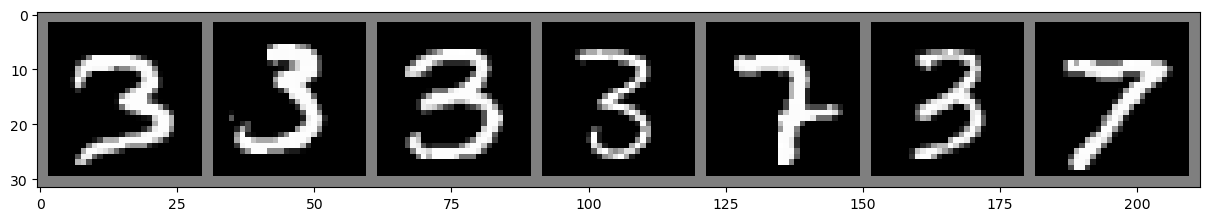

In [39]:
def display_image_grid(images, rows, cols):
    grid = torchvision.utils.make_grid(images, nrow=cols)
    grid = grid / 2 + 0.5  # Unnormalize
    plt.figure(figsize=(15, 15))  # Adjust the size as needed
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Number of images per grid
images_per_grid = 128  # for example, a 4x4 grid

# Calculate rows and columns for the grid
cols = 10  # Number of columns
rows = images_per_grid // cols

# Display the images in grids
for i in range(0, len(displayPos), images_per_grid):
    selected_indices = displayPos[i:i+images_per_grid]
    selected_images = torch.stack([all_images[index] for index in selected_indices])
    display_image_grid(selected_images, rows, cols)

for i in range(0, len(falsePos), images_per_grid):
    selected_indices = falsePos[i:i+images_per_grid]
    selected_images = torch.stack([all_images[index] for index in selected_indices])
    display_image_grid(selected_images, rows, cols)

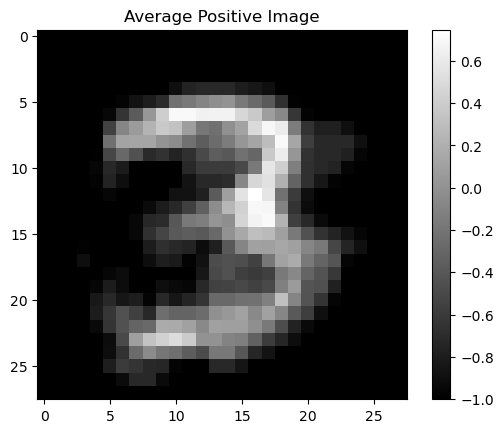

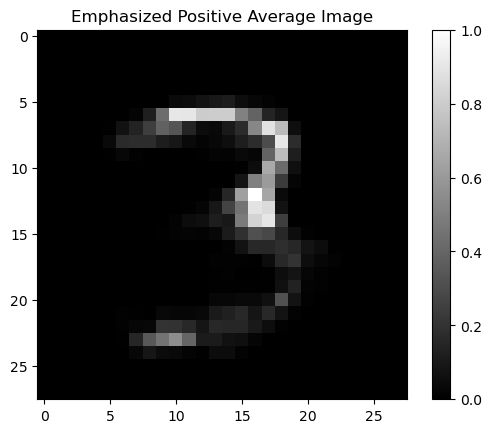

In [40]:
images_subset = torch.stack([all_images[i] for i in displayPos])
average_image = images_subset.float().mean(dim=0).squeeze()
plt.imshow(average_image, cmap='gray')
plt.title("Average Positive Image")
plt.colorbar()
plt.show()

normalized_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Apply a power law transformation to increase contrast, emphasizing the bright pixels
# Squaring the normalized pixel values will make high values brighter and low values dimmer
emphasized_positive_image = normalized_image ** 4

# Plot the emphasized average image
plt.imshow(emphasized_positive_image, cmap='gray')
plt.title("Emphasized Positive Average Image")
plt.colorbar()
plt.show()

In [41]:
images_subset = torch.stack([all_images[i] for i in falsePos])
average_image = images_subset.float().mean(dim=0).squeeze()
plt.imshow(average_image, cmap='gray')
plt.title("Average Negative Image")
plt.colorbar()
plt.show()

normalized_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Apply a power law transformation to increase contrast, emphasizing the bright pixels
# Squaring the normalized pixel values will make high values brighter and low values dimmer
emphasized_negative_image = normalized_image ** 4

# Plot the emphasized average image
plt.imshow(emphasized_negative_image, cmap='gray')
plt.title("Emphasized Average Negative Image")
plt.colorbar()
plt.show()

RuntimeError: stack expects a non-empty TensorList

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# TODO do some math to average pos and neg not just > or <

# Create an empty RGB image
heatmap = np.zeros((*emphasized_positive_image.shape, 3))

# Define a threshold for neutrality
threshold = 0.05  # Adjust based on your data's scale

# Fill the heatmap
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        pos = emphasized_positive_image[i, j]
        neg = emphasized_negative_image[i, j]
        if np.abs(pos - neg) < threshold:  # Neutral
            heatmap[i, j] = [0, 0, 0]  # White for neutral, change to [0, 0, 0] for black
        elif(pos>0 and neg>0):  # Negative
            heatmap[i, j] = [pos, 0, neg]  # Blue intensity based on negative value

# Display the heatmap
plt.imshow(heatmap)
plt.title("Merged Heatmap of Positive and Negative")
plt.show()

NameError: name 'emphasized_negative_image' is not defined

In [43]:
trueNegData = []
truePosData = []

# Function to fetch data for each image index
def fetch_data_for_images(image_indices):
    data_array = []
    for index in image_indices:
        data = explainable_net.get_node_input(layer_name, node_index, index)
        data_array.append(data)
    return data_array

# Fetching data for trueNeg and truePos
trueNegData = fetch_data_for_images(trueNeg)
truePosData = fetch_data_for_images(truePos)

In [17]:
def test_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


In [18]:
# Test the model
test_model(model, testloader)


[Epoch: 1, Batch:   100] loss: 0.913
[Epoch: 1, Batch:   200] loss: 0.240
[Epoch: 1, Batch:   300] loss: 0.214
[Epoch: 1, Batch:   400] loss: 0.136
[Epoch: 1, Batch:   500] loss: 0.128
[Epoch: 1, Batch:   600] loss: 0.099
[Epoch: 1, Batch:   700] loss: 0.086
[Epoch: 1, Batch:   800] loss: 0.079
[Epoch: 1, Batch:   900] loss: 0.086
[Epoch: 1, Batch:  1000] loss: 0.085
[Epoch: 1, Batch:  1100] loss: 0.079
[Epoch: 1, Batch:  1200] loss: 0.082
[Epoch: 1, Batch:  1300] loss: 0.072
[Epoch: 1, Batch:  1400] loss: 0.078
[Epoch: 1, Batch:  1500] loss: 0.078
[Epoch: 1, Batch:  1600] loss: 0.079
[Epoch: 1, Batch:  1700] loss: 0.071
[Epoch: 1, Batch:  1800] loss: 0.061
[Epoch: 2, Batch:   100] loss: 0.066
[Epoch: 2, Batch:   200] loss: 0.053
[Epoch: 2, Batch:   300] loss: 0.060
[Epoch: 2, Batch:   400] loss: 0.046
[Epoch: 2, Batch:   500] loss: 0.050
[Epoch: 2, Batch:   600] loss: 0.047
[Epoch: 2, Batch:   700] loss: 0.037
[Epoch: 2, Batch:   800] loss: 0.036
[Epoch: 2, Batch:   900] loss: 0.055
[